In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import os
os.chdir('../Dataset/Train')
os.getcwd()

'C:\\Users\\Daniele\\PycharmProjects\\LipNetProve\\Dataset\\Train'

In [3]:
data=[]
for l in os.listdir():
    os.chdir(l)
    for m in os.listdir():
        data.append([l+'/'+m, l])
    os.chdir('..')

In [4]:
data

[['a/F04_phrases01_02.jpg', 'a'],
 ['a/F04_phrases01_03.jpg', 'a'],
 ['a/F04_phrases01_04.jpg', 'a'],
 ['a/F04_phrases01_05.jpg', 'a'],
 ['a/F04_phrases01_06.jpg', 'a'],
 ['a/F04_phrases01_07.jpg', 'a'],
 ['a/F05_phrases01_01.jpg', 'a'],
 ['a/F05_phrases01_02.jpg', 'a'],
 ['a/F05_phrases01_03.jpg', 'a'],
 ['a/F05_phrases01_04.jpg', 'a'],
 ['a/F05_phrases01_05.jpg', 'a'],
 ['a/F05_phrases01_06.jpg', 'a'],
 ['a/F05_phrases01_07.jpg', 'a'],
 ['a/F05_phrases01_08.jpg', 'a'],
 ['a/F05_phrases01_09.jpg', 'a'],
 ['a/F05_phrases01_10.jpg', 'a'],
 ['a/F06_phrases01_01.jpg', 'a'],
 ['a/F06_phrases01_02.jpg', 'a'],
 ['a/F06_phrases01_03.jpg', 'a'],
 ['a/F06_phrases01_04.jpg', 'a'],
 ['a/F06_phrases01_05.jpg', 'a'],
 ['a/F06_phrases01_07.jpg', 'a'],
 ['a/F06_phrases01_08.jpg', 'a'],
 ['a/F06_phrases01_09.jpg', 'a'],
 ['a/F06_phrases01_10.jpg', 'a'],
 ['a/F07_phrases01_01.jpg', 'a'],
 ['a/F07_phrases01_02.jpg', 'a'],
 ['a/F07_phrases01_03.jpg', 'a'],
 ['a/F07_phrases01_04.jpg', 'a'],
 ['a/F07_phras

In [5]:
os.getcwd()

'C:\\Users\\Daniele\\PycharmProjects\\LipNetProve\\Dataset\\Train'

In [6]:
import csv
os.chdir('../../codes')
header = ['filename', 'label']

with open('training_labels.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(data)

In [7]:
train_data = pd.read_csv('training_labels.csv')
Y = train_data[['label']]
#80/20
kf = KFold(n_splits = 5)

skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)

In [8]:
idg = ImageDataGenerator(rescale=1./255)

In [9]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [10]:
def create_new_model():
    import os
    import numpy as np
    from keras.models import Sequential # To initialise the nn as a sequence of layers
    from keras.layers import Convolution2D # To make the convolution layer for 2D images
    from keras.layers import MaxPooling2D #
    from keras.layers import Flatten
    from keras.layers import Dense
    from keras.layers import Dropout
    from keras.callbacks import CSVLogger
    from tensorflow.keras.optimizers import RMSprop
    from keras.layers import BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from keras.models import load_model
    from keras.callbacks import ModelCheckpoint
    from keras.layers import Activation
    from keras.layers import GlobalAveragePooling2D



    csv = CSVLogger("2_adam.log")
    #filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
    #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


    # Initialising the CNN
    classifier = Sequential()

    # Step 1 - Convolution
    classifier.add(Convolution2D(32, (2, 2), input_shape=(224, 224, 1), activation='relu', strides=2, name='convo1'))
    classifier.add(Convolution2D(64, (3, 3), activation='relu', name='convo2'))
    # Step 1 - Pooling
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Step 2 - Convolution
    classifier.add(Convolution2D(64, (3, 3), activation='relu', name='convo3'))
    # Step 2 - Pooling
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    # Step 3 - Convolution
    classifier.add(Convolution2D(64, (3, 3), activation='relu', name='convo4'))
    # Step 3 - Pooling
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    #Step 4 - Flattening

    classifier.add(Flatten())

    classifier.add(BatchNormalization())
    classifier.add(Dropout((0.5)))
    classifier.add(Dense(1024, activation='relu'))

    '''classifier.add(BatchNormalization())
    classifier.add(Dropout((0.5)))
    classifier.add(Dense(512, activation = 'relu'))
    '''

    classifier.add(BatchNormalization())
    classifier.add(Dropout((0.4)))
    classifier.add(Dense(20, activation='softmax'))

    return classifier


In [11]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = 'saved_models//'
fold_var = 1

for train_index, val_index in skf.split(np.zeros(2585),Y):
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]

	train_data_generator = idg.flow_from_dataframe(training_data, directory = '../Dataset/Train',
						       x_col = "filename", y_col = "label",
						       class_mode = "categorical", shuffle = True,color_mode="grayscale",target_size=(224,224),batchsize=32)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory =  '../Dataset/Train',
							x_col = "filename", y_col = "label",
							class_mode = "categorical", shuffle = True,color_mode="grayscale",target_size=(224,224),batchsize=32)

	# CREATE NEW MODEL
	model = create_new_model()
	# COMPILE NEW MODEL
	model.compile(loss='categorical_crossentropy',
		      optimizer="Adam",
		      metrics=['accuracy'])

	# CREATE CALLBACKS
	checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var),
							monitor='val_accuracy', verbose=1,
							save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
	history = model.fit(train_data_generator,
			    epochs=40,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)
	#PLOT HISTORY
	#		:
	#		:

	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights("saved_models/model_"+str(fold_var)+".h5")

	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))

	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])

	tf.keras.backend.clear_session()

	fold_var += 1

Found 2068 validated image filenames belonging to 20 classes.
Found 517 validated image filenames belonging to 20 classes.
Epoch 1/40
65/65 [==============================] - ETA: 0s - loss: 3.3666 - accuracy: 0.1480
Epoch 00001: val_accuracy improved from -inf to 0.05803, saving model to saved_models\model_1.h5
65/65 [==============================] - 33s 505ms/step - loss: 3.3666 - accuracy: 0.1480 - val_loss: 2.9547 - val_accuracy: 0.0580
Epoch 2/40
65/65 [==============================] - ETA: 0s - loss: 2.1815 - accuracy: 0.3839
Epoch 00002: val_accuracy improved from 0.05803 to 0.06383, saving model to saved_models\model_1.h5
65/65 [==============================] - 32s 487ms/step - loss: 2.1815 - accuracy: 0.3839 - val_loss: 2.9619 - val_accuracy: 0.0638
Epoch 3/40
65/65 [==============================] - ETA: 0s - loss: 1.4325 - accuracy: 0.5580
Epoch 00003: val_accuracy improved from 0.06383 to 0.08124, saving model to saved_models\model_1.h5
65/65 [===========================

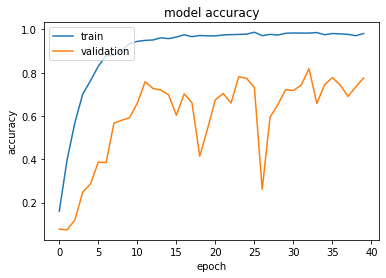

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy']) #validation
plt.plot(history.history['val_accuracy']) #train
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()